# Problem Definition

Predict which pumps are functional, which need some repairs, and which don't work at all. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

# Importing Libraries

In [3]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [4]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
import geopy.distance
%matplotlib inline 

In [5]:
from xgboost import XGBClassifier

# Importing Datasets

In [7]:
train_value = pd.read_csv("Train_Set_Values.csv")
train_label = pd.read_csv("Train_Set_Labels.csv")
test = pd.read_csv("Test_Set_Values.csv")

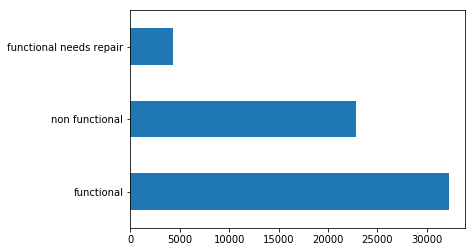

In [8]:
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
train_label.status_group.value_counts().plot(kind='barh', color=palette)

# Data Preprations

## Combining Train Values and Labels

In [9]:
train_data = train_value.merge(train_label, how = "outer", on = "id", sort = True)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

C:\Users\ysami\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


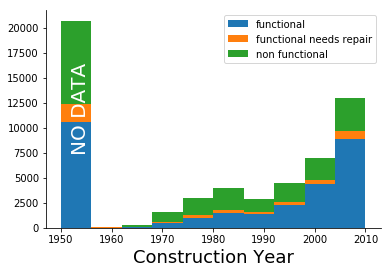

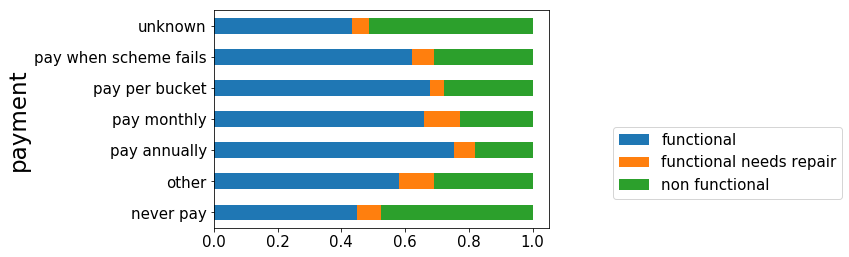

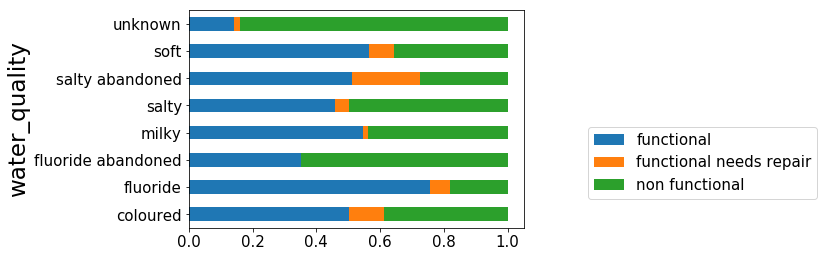

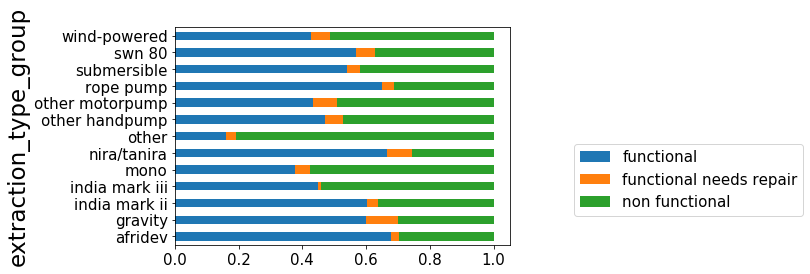

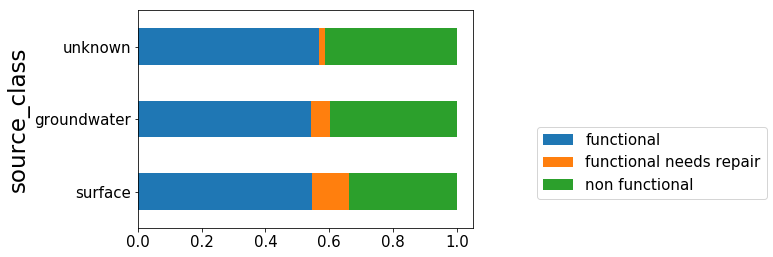

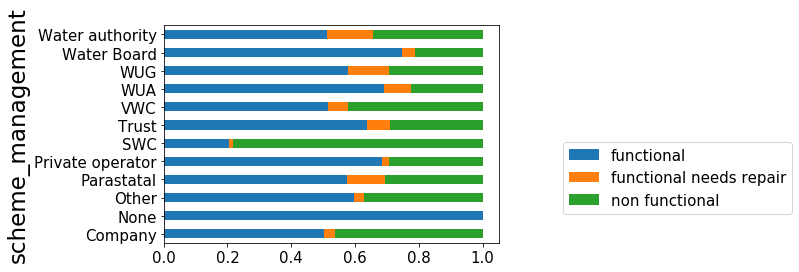

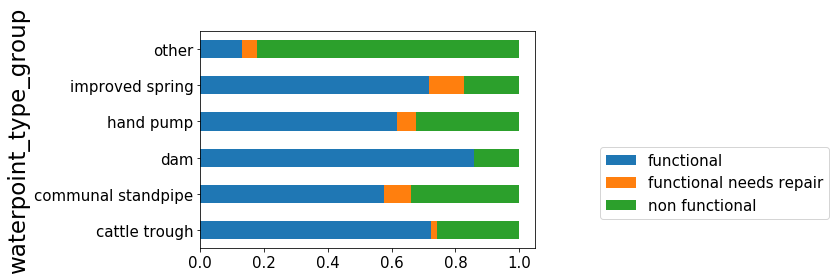

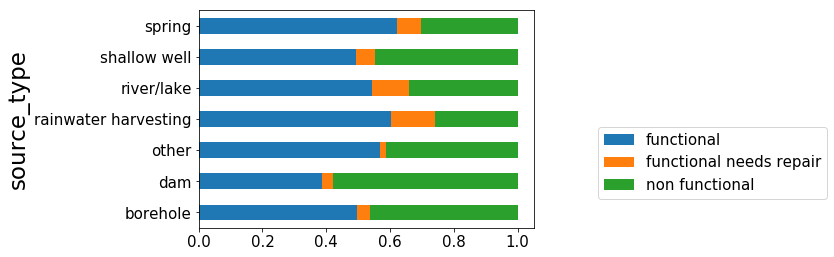

In [10]:
train_data.construction_year=pd.to_numeric(train_data.construction_year)
train_data.loc[train_data.construction_year <= 0, train_data.columns=='construction_year'] = 1950

hist1=train_data[train_data.status_group == 'functional'].construction_year
hist2=train_data[train_data.status_group == 'functional needs repair'].construction_year
hist3=train_data[train_data.status_group == 'non functional'].construction_year

n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)

sns.despine()

factorstoplot=['payment','water_quality','extraction_type_group','source_class','scheme_management','waterpoint_type_group','source_type']
for i in range(1,len(factorstoplot)+1):
   
    thisFactor=factorstoplot[i-1]
    sumfactor=train_data.groupby([thisFactor]).status_group.count()
    temp=pd.DataFrame(train_data.groupby([thisFactor]).status_group.value_counts()/sumfactor)
    temp['status']=temp.index.get_level_values('status_group')
    temp['source']=temp.index.get_level_values(thisFactor)
    temp.columns=['n','status',thisFactor]
    temp=temp.pivot(index=thisFactor, columns='status', values='n')
    temp['tot']=temp.sum(axis=1)
    temp.sort_values(by='tot', ascending=True)[['functional','functional needs repair','non functional']].plot(kind='barh', stacked='True', color=sns.color_palette(), fontsize=15,legend=False)
    plt.legend( loc='upper right', bbox_to_anchor=(1.9, 0.5),fontsize=15)
    plt.ylabel(thisFactor, fontsize=23)

Convert Recorded date into date type and check max

In [11]:
train_data['date_recorded']=train_data.date_recorded.apply(pd.to_datetime)

In [12]:
train_data['date_recorded'].max()

Timestamp('2013-12-03 00:00:00')

## Combining Train and Test Values for Feauture Engineering Processes

All missing values of latitude, longitude and height (listed as 0s) are converted to the mean value within their administrative region
For categorical variables, values that are rare (less than 20 occurences) are converted into "Others"
Categorical variables are converted into numbers
A new variable is introduced: timeago (how long ago the pump was checked) 

In [59]:
combined_df=train_value.append(test)

In [60]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
r

In [61]:
combined_df.construction_year=pd.to_numeric(combined_df.construction_year)
combined_df.loc[combined_df.construction_year <= 0, combined_df.columns=='construction_year'] = 1950

In [62]:
a= combined_df[combined_df["longitude"] < 1]
a.iloc[:,combined_df.columns == "latitude"]= np.nan
a.iloc[:,combined_df.columns == "longitude"]= np.nan
combined_df[combined_df["longitude"] < 1] = a
combined_df["longitude"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
combined_df["latitude"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude
combined_df[combined_df["latitude"].isnull()]


C:\Users\ysami\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [63]:


distances = combined_df[['id','longitude','latitude']]
distances =distances.sort_values(by=['longitude','latitude'])
distances['coords']=distances[['longitude','latitude']].values.tolist()

In [18]:
distances

,id,longitude,latitude,coords
35351,27121,29.607122,-4.906265,"[29.6071219, -4.90626498]"
38853,36714,29.607201,-4.903016,"[29.60720109, -4.90301609]"
40328,53529,29.610321,-4.912941,"[29.61032056, -4.91294137]"
24082,43648,29.610965,-4.906904,"[29.61096482, -4.90690408]"
53947,45482,29.611947,-4.837695,"[29.61194674, -4.83769501]"
13504,14210,29.612507,-4.837919,"[29.61250689, -4.83791856]"
56955,23336,29.612763,-4.838288,"[29.61276296, -4.8382878]"
13719,55027,29.612776,-4.904176,"[29.61277618, -4.90417553]"
18048,56913,29.613443,-4.904096,"[29.61344309, -4.9040965]"
7607,68081,29.614416,-4.838150,"[29.61441634, -4.83814965]"


In [64]:
shift_distances=distances.shift(1).loc[:,'coords' ]

In [20]:
shift_distances

35351                                   NaN
38853             [29.6071219, -4.90626498]
40328            [29.60720109, -4.90301609]
24082            [29.61032056, -4.91294137]
53947            [29.61096482, -4.90690408]
13504            [29.61194674, -4.83769501]
56955            [29.61250689, -4.83791856]
13719             [29.61276296, -4.8382878]
18048            [29.61277618, -4.90417553]
7607              [29.61344309, -4.9040965]
7674             [29.61441634, -4.83814965]
12052             [29.6168718, -4.90401535]
5047              [29.61847919, -4.8969754]
46449            [29.62943461, -4.85538192]
13222            [29.63058268, -4.84845719]
1301       [29.636467100000004, -4.8575063]
7305      [29.638814899999996, -4.85798456]
14919            [29.63890417, -4.76458297]
23916            [29.63902587, -4.88950883]
11392            [29.64015595, -4.77047171]
9103             [29.64041145, -4.79742611]
37551            [29.64083261, -4.87682639]
14304            [29.64096292, -

In [65]:
distances_2 = pd.concat([distances, shift_distances], axis=1)

In [66]:
distances_2.columns =['id','longitude','latitude','coord_1','coords_2']
distances_2['long2']=pd.to_numeric(distances_2['coords_2'].str[0])
distances_2['lat2']=pd.to_numeric(distances_2['coords_2'].str[1])

In [67]:
distances_2=distances_2.fillna(0)

In [24]:
distances_2

,id,longitude,latitude,coord_1,coords_2,long2,lat2
35351,27121,29.607122,-4.906265,"[29.6071219, -4.90626498]",0,0.000000,0.000000
38853,36714,29.607201,-4.903016,"[29.60720109, -4.90301609]","[29.6071219, -4.90626498]",29.607122,-4.906265
40328,53529,29.610321,-4.912941,"[29.61032056, -4.91294137]","[29.60720109, -4.90301609]",29.607201,-4.903016
24082,43648,29.610965,-4.906904,"[29.61096482, -4.90690408]","[29.61032056, -4.91294137]",29.610321,-4.912941
53947,45482,29.611947,-4.837695,"[29.61194674, -4.83769501]","[29.61096482, -4.90690408]",29.610965,-4.906904
13504,14210,29.612507,-4.837919,"[29.61250689, -4.83791856]","[29.61194674, -4.83769501]",29.611947,-4.837695
56955,23336,29.612763,-4.838288,"[29.61276296, -4.8382878]","[29.61250689, -4.83791856]",29.612507,-4.837919
13719,55027,29.612776,-4.904176,"[29.61277618, -4.90417553]","[29.61276296, -4.8382878]",29.612763,-4.838288
18048,56913,29.613443,-4.904096,"[29.61344309, -4.9040965]","[29.61277618, -4.90417553]",29.612776,-4.904176
7607,68081,29.614416,-4.838150,"[29.61441634, -4.83814965]","[29.61344309, -4.9040965]",29.613443,-4.904096


In [68]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [69]:
distances_2['dist'] = distances_2.apply(lambda x: haversine_np(x[1], x[2], x[5], x[6]), axis = 1)

In [27]:
distances_2

,id,longitude,latitude,coord_1,coords_2,long2,lat2,dist
35351,27121,29.607122,-4.906265,"[29.6071219, -4.90626498]",0,0.000000,0.000000,3330.919326
38853,36714,29.607201,-4.903016,"[29.60720109, -4.90301609]","[29.6071219, -4.90626498]",29.607122,-4.906265,0.361140
40328,53529,29.610321,-4.912941,"[29.61032056, -4.91294137]","[29.60720109, -4.90301609]",29.607201,-4.903016,1.155760
24082,43648,29.610965,-4.906904,"[29.61096482, -4.90690408]","[29.61032056, -4.91294137]",29.610321,-4.912941,0.674676
53947,45482,29.611947,-4.837695,"[29.61194674, -4.83769501]","[29.61096482, -4.90690408]",29.610965,-4.906904,7.691634
13504,14210,29.612507,-4.837919,"[29.61250689, -4.83791856]","[29.61194674, -4.83769501]",29.611947,-4.837695,0.066815
56955,23336,29.612763,-4.838288,"[29.61276296, -4.8382878]","[29.61250689, -4.83791856]",29.612507,-4.837919,0.049876
13719,55027,29.612776,-4.904176,"[29.61277618, -4.90417553]","[29.61276296, -4.8382878]",29.612763,-4.838288,7.321782
18048,56913,29.613443,-4.904096,"[29.61344309, -4.9040965]","[29.61277618, -4.90417553]",29.612776,-4.904176,0.074360
7607,68081,29.614416,-4.838150,"[29.61441634, -4.83814965]","[29.61344309, -4.9040965]",29.613443,-4.904096,7.329143


In [70]:
location=distances_2[['id','dist']]

In [71]:
combined_df=combined_df.merge(location, left_on='id', right_on='id', how='inner')

In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 74249
Data columns (total 42 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null object
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
num_private              74250 non-null int64
basin                    74250 non-null object
subvillage               73780 non-null object
region                   74250 non-null object
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null object
r

## Factors Creation

In [72]:
factorschange=[x for x in combined_df.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time','dist']]

for factor in factorschange:


    values_factor=combined_df[factor].value_counts()
    lessthen=values_factor[values_factor < 20]
    listnow=combined_df.installer.isin(list(lessthen.keys()))
    combined_df.loc[listnow,factor] = 'Others'

    # names to numbers
    combined_df[factor] = preprocessing.LabelEncoder().fit_transform(combined_df[factor].astype(str))

# Data Cleaning

## Null value treatment / imputation

In [73]:
a= combined_df[combined_df["gps_height"] < 1]
a.iloc[:,combined_df.columns == "gps_height"]= np.nan
combined_df[combined_df["gps_height"] < 1] = a
combined_df["gps_height"] = combined_df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

C:\Users\ysami\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
combined_df.columns[combined_df.isnull().any()].tolist()

[]

combined_df.groupby("region_code").gps_height.mean()

combined_df=combined_df.fillna(combined_df.mean())

## Normalization (Logging skewed vars)

In [75]:
combined_df.population = combined_df.population.apply(lambda x: np.log10(x+1))

## Outlier removal

## New feature creation

In [76]:
combined_df['Current_Date']='2014-01-01'

In [77]:
combined_df['operation_time']=combined_df.Current_Date.apply(pd.to_datetime)-combined_df.date_recorded.apply(pd.to_datetime)
combined_df['operation_time']= combined_df.operation_time.astype('timedelta64[D]').astype(int)

In [78]:
combined_df['month']=pd.to_datetime(combined_df.date_recorded).dt.month

In [79]:
combined_df['age']=combined_df.Current_Date.apply(pd.to_datetime)-combined_df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))
combined_df['age']= combined_df.age.astype('timedelta64[Y]').astype(int)

In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 74249
Data columns (total 46 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null int64
date_recorded            74250 non-null object
funder                   74250 non-null int64
gps_height               74250 non-null float64
installer                74250 non-null int64
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null int64
num_private              74250 non-null int64
basin                    74250 non-null int64
subvillage               74250 non-null int64
region                   74250 non-null int64
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null int64
ward                     74250 non-null int64
population               74250 non-null float64
public_meeting           74250 non-null int64
recorded

# Cross-Validation: Data Sepertaion

In [80]:
training_set=combined_df[:len(train_value)] 

In [81]:
test_set=combined_df[len(train_value):]

## Split Datasets

In [82]:
# use these variables - room for improvement here
#factors=[u'funder', 
      # u'installer', u'dist', u'wpt_name',
      # u'basin',  u'region_code', u'district_code',u'lga', u'ward', u'population', u'public_meeting',
       #  u'longitude', u'latitude',
      # u'scheme_management', u'scheme_name', u'permit', u'construction_year',u'age',
      # u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       #u'management', u'management_group', u'payment', u'payment_type',
      # u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       #u'source', u'source_type', u'source_class', u'waterpoint_type',
      # u'waterpoint_type_group','month','operation_time']


factors=[u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group','month','operation_time','age']


# factors = ["funder","installer","management",
#                "region","lga","population",
#                "latitude","longitude","gps_height",
#                "scheme_management",
#                "public_meeting","permit",
#                "water_quality","quantity",
#                "payment_type","source","source_class",
#                "management","management_group",
#                "basin","extraction_type","waterpoint_type",
#                "timeago"]

X_train, X_test, y_train, y_test = train_test_split(training_set[factors], train_label.status_group, test_size=0.1, random_state=10)


print (len(X_train), len(X_test))

53460 5940


training_set = training_set.merge(train_label, how = "inner", on = "id", sort = True)

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 6191 to 17673
Data columns (total 38 columns):
funder                   53460 non-null int64
gps_height               53460 non-null float64
installer                53460 non-null int64
longitude                53460 non-null float64
latitude                 53460 non-null float64
wpt_name                 53460 non-null int64
basin                    53460 non-null int64
subvillage               53460 non-null int64
region                   53460 non-null int64
region_code              53460 non-null int64
district_code            53460 non-null int64
lga                      53460 non-null int64
ward                     53460 non-null int64
population               53460 non-null float64
public_meeting           53460 non-null int64
scheme_management        53460 non-null int64
scheme_name              53460 non-null int64
permit                   53460 non-null int64
construction_year        53460 non-null int64
extrac

# Models Intitiation

## Train and Score Models

53460 5940
Random Forest 0.8092592592592592
Decision Tree 0.6728956228956229
Extra Trees Classifiers 0.8126262626262626
XGboost Classifiers 0.7494949494949495


C:\Users\ysami\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0,0.5,'Score')

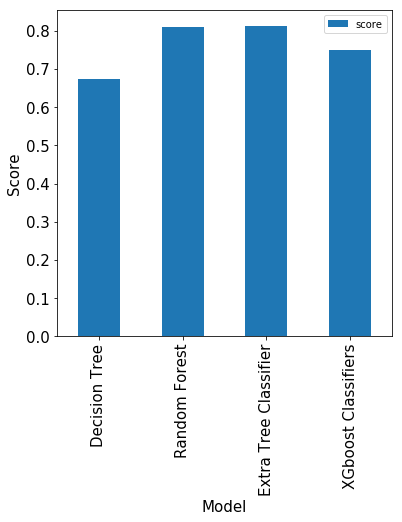

In [83]:

print (len(X_train), len(X_test))
modelRFC = RandomForestClassifier(n_estimators=300,min_samples_split=2,min_samples_leaf=1,criterion='gini',bootstrap=True,)


X_test=(X_test - X_test.min())/(X_test.max() - X_test.min())
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

modelRFC.fit(X_train, y_train)

modelETC = ExtraTreesClassifier(n_estimators=1000,min_samples_split=10)
modelETC.fit(X_train, y_train)


modelXclass = XGBClassifier()  # and for classifier  
modelXclass.fit(X_train, y_train)  
 

modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

scoreRFC= modelRFC.score(X_test,y_test)
scoreDTC= modelDTC.score(X_test,y_test)
scoreETC= modelETC.score(X_test,y_test)

scoreXclass= modelXclass.score(X_test,y_test)

print ('Random Forest' ,scoreRFC)
print ('Decision Tree', scoreDTC)
print ('Extra Trees Classifiers', scoreETC)
print ('XGboost Classifiers', scoreXclass)

pd.DataFrame([
    ("Decision Tree", scoreDTC),
    ("Random Forest", scoreRFC),
    ("Extra Tree Classifier", scoreETC),
    ("XGboost Classifiers", scoreXclass),
    ], columns=["Model", "score"]).plot(x="Model", y="score", kind="Bar", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)

## XG_BOOST

## Random Forest

## Decision Trees

## Regression

## SVM

## KNN

## Naive Bayes

# Cross Validation

## Confusion Matrix

Confusion matrix, without normalization
[[3171   16   81]
 [ 155  218   39]
 [ 274   16 1970]]
Normalized confusion matrix
[[0.97 0.   0.02]
 [0.38 0.53 0.09]
 [0.12 0.01 0.87]]


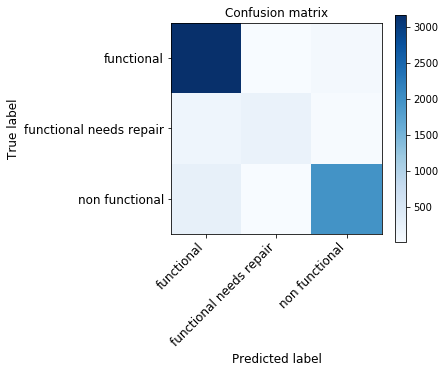

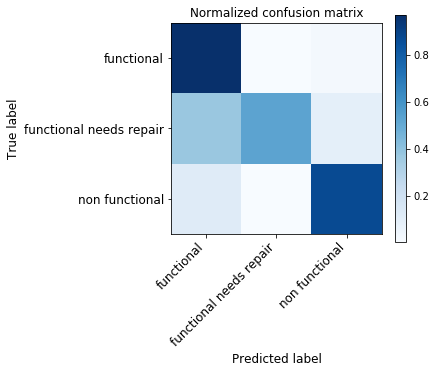

Test Score 0.9021885521885522


In [57]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)


# Compute confusion matrix
cm = confusion_matrix(y_test, modelETC.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()
print ('Test Score', cm.diagonal().sum()/float(cm.sum()))

## ROC Curve

## RMSE

## Identify over-fitting

# Decide On Optimal Model

## Ensemble

# Re-join train and validation datasets

In [232]:
combined_df=training_set.append(test_set)

# Prediction Result

In [58]:
model=modelETC

X_train=training_set[factors]
y_train =train_label.status_group
X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())

model.fit(X_train, y_train)



X_topredict=test_set[factors]
X_topredict=(X_topredict - X_topredict.min())/(X_topredict.max() - X_topredict.min())
predict=model.predict(X_topredict)


test_set['status_group']=predict

test_set[['id','status_group']].to_csv('outputETC.csv',index=False)

C:\Users\ysami\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [50]:
from sklearn.cross_validation import cross_val_score

for i in [2,5,10,20]:
    for j in ['auto',5,10,20]:        
        model = RandomForestClassifier(n_estimators=1000,min_samples_split=i,  max_features=j, random_state=3134)
        X_train=training_set[factors]
        y_train =train_label.status_group
        X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())
        s=cross_val_score(model, X_train, y_train, scoring=None, cv=None, pre_dispatch='2*n_jobs')
        print (i,j,s.mean(), s.std())

2 auto 0.80496632996633 0.0008809074378418372
2 5 0.8046127946127947 0.0005122937392156105
2 10 0.804023569023569 0.0012235247347209969
2 20 0.8031818181818181 0.0014290936316298955
5 auto 0.8087373737373738 0.0003273101362832188
5 5 0.8089057239057239 0.0007483538980098824
5 10 0.8086868686868688 0.0005817223078508805


KeyboardInterrupt: 

In [52]:
from sklearn.cross_validation import cross_val_score

for i in [2,5,10,20]:
    for j in ['auto',5,10,20]:
        model = ExtraTreesClassifier(n_estimators=1000,min_samples_split=i,  max_features=j, random_state=3134)
        X_train=training_set[factors]
        y_train =train_label.status_group
        X_train=(X_train - X_train.min())/(X_train.max() - X_train.min())
        s=cross_val_score(model, X_train, y_train, scoring=None, cv=None, pre_dispatch='2*n_jobs')
        print (i,j,s.mean(), s.std())

2 auto 0.7941750841750842 0.002619238643034504
2 5 0.7946969696969696 0.0019178623783886177
2 10 0.7925252525252525 0.002294878952773694
2 20 0.79003367003367 0.002166556130908244
5 auto 0.8043939393939393 0.001980673894053303
5 5 0.8039057239057238 0.002427863924232675
5 10 0.8022558922558923 0.001600478054397343
5 20 0.7984511784511784 0.0013003347823116135
10 auto 0.8077104377104377 0.0012235247347209808
10 5 0.8071380471380473 0.001865423182056497
10 10 0.805993265993266 0.001792435239623762
10 20 0.8037373737373738 0.0018354029186406088
20 auto 0.8028282828282829 0.0014713072738344298
20 5 0.8022727272727272 0.0010126231139274547
20 10 0.8038552188552188 0.0014651301496320017
20 20 0.8036363636363637 0.0014497676863037537
